In [ ]:
import os
import sys
import h5py
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from glob import glob
from sklearn.metrics import confusion_matrix

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14

from theme import colors

from src.dataset import StructuresDataset, collate_batch_features, select_by_sid, select_by_interface_types
from src.data_encoding import encode_structure, encode_features, extract_topology, categ_to_resnames, resname_to_categ
from src.structure import data_to_structure, encode_bfactor
from src.structure_io import save_pdb, read_pdb
from src.scoring import bc_scoring, bc_score_names

In [ ]:
# model parameters
# R3
#save_path = "model/save/i_v3_0_2021-05-27_14-27"  # 89
#save_path = "model/save/i_v3_1_2021-05-28_12-40"  # 90
# R4
#save_path = "model/save/i_v4_0_2021-09-07_11-20"  # 89
save_path = "model/save/i_v4_1_2021-09-07_11-21"  # 91

# select saved model
model_filepath = os.path.join(save_path, 'model_ckpt.pt')
#model_filepath = os.path.join(save_path, 'model.pt')

In [ ]:
# add module to path
if save_path not in sys.path:
    sys.path.insert(0, save_path)
    
# load functions
from config import config_model, config_data
from data_handler import Dataset
from model import Model

In [ ]:
# define device
device = pt.device("cuda")

# create model
model = Model(config_model)

# reload model
model.load_state_dict(pt.load(model_filepath, map_location=pt.device("cpu")))

# set model to inference
model = model.eval().to(device)

In [ ]:
# set up dataset
dataset = Dataset("datasets/contacts_rr5A_64nn_8192.h5")

# selected structures
sids_sel = np.genfromtxt("datasets/subunits_validation_set.txt", dtype=np.dtype('U'))

# filter dataset
m = select_by_sid(dataset, sids_sel) # select by sids
m &= select_by_interface_types(dataset, config_data['l_types'], np.concatenate(config_data['r_types']))  # select by interface type

# update dataset selection
dataset.update_mask(m)

# set dataset types
dataset.set_types(config_data['l_types'], config_data['r_types'])

# debug print
print(len(dataset))

79765


In [ ]:
# parameters
N = 1024*8

# select data randomly
ids = np.arange(len(dataset))
np.random.shuffle(ids)

# compute confidence for correct and wrong predictions
c0p_l, c1p_l = [], []
c0n_l, c1n_l = [], []
with pt.no_grad():
    for i in tqdm(ids[:N]):
        # get data
        X, ids_topk, q, M, y = dataset[i]

        # pack data and setup sink (IMPORTANT)
        X, ids_topk, q, M = collate_batch_features([[X, ids_topk, q, M]])

        # run model
        z = model(X.to(device), ids_topk.to(device), q.to(device), M.float().to(device))

        # prediction
        p = pt.sigmoid(z)
        
        # protein interface only
        p = p[:,0]
        y = y[:,0]
        
        # correct predictions mask
        m = (pt.round(p.cpu()) == y)
        
        # confidence estimate for positive predictions only
        mp = (p.cpu() > 0.5)
        if pt.any(mp):
            # store results
            c0p_l.append(p[mp & m].cpu().numpy())
            c1p_l.append(p[mp & (~m)].cpu().numpy())

        # confidence estimate for negative predictions only
        mn = (p.cpu() < 0.5)
        if pt.any(mn):
            # store results
            c0n_l.append(p[mn & m].cpu().numpy())
            c1n_l.append(p[mn & (~m)].cpu().numpy())
        
# pack results
c0p = np.concatenate(c0p_l)
c1p = np.concatenate(c1p_l)
c0n = np.concatenate(c0n_l)
c1n = np.concatenate(c1n_l)

100%|████████████████████████████████████████████████████████████████████████████| 8192/8192 [13:12<00:00, 10.34it/s]


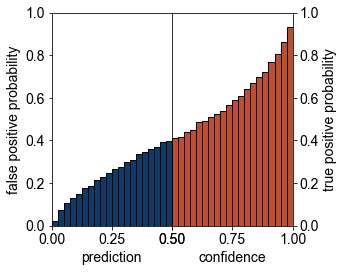

In [10]:
# parameters
n = 20

# count predictions quality in confidence intervals
h0p, x0p = np.histogram(c0p, bins=n, range=(0.5,1.0))
h1p, x1p = np.histogram(c1p, bins=n, range=(0.5,1.0))
h0n, x0n = np.histogram(c0n, bins=n, range=(0.0,0.5))
h1n, x1n = np.histogram(c1n, bins=n, range=(0.0,0.5))

# plot
plt.figure(figsize=(5,4))
gs = gridspec.GridSpec(1,2)
gs.update(wspace=0.0, hspace=0.0)

# left
plt.subplot(gs[0])
plt.bar(0.5*(x0n[:-1]+x0n[1:]), h1n / (h0n+h1n), width=(x0n[1]-x0n[0]), edgecolor='k', color=colors[1], label='negative')
plt.xlim(0.0, 0.5)
plt.ylim(0.0, 1.0)
#plt.legend(loc='best')
plt.xlabel('prediction')
plt.ylabel('false positive probability')

# right
ax = plt.subplot(gs[1])
plt.bar(0.5*(x0p[:-1]+x0p[1:]), 1.0 - h1p / (h0p+h1p), width=(x0p[1]-x0p[0]), edgecolor='k', color=colors[0], label='positive')
plt.xlim(0.5, 1.0)
plt.ylim(0.0, 1.0)
#plt.legend(loc='best')
plt.xlabel('confidence')
plt.ylabel('true positive probability')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.tight_layout()
plt.savefig("results/interface_ppi_confidence.svg")
plt.savefig("results/interface_ppi_confidence.png", dpi=300)
plt.show()

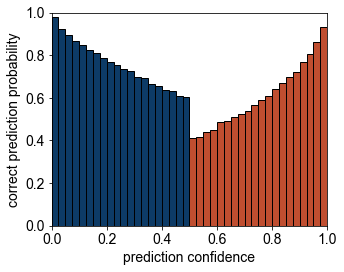

In [11]:
# parameters
n = 20

# count predictions quality in confidence intervals
h0p, x0p = np.histogram(c0p, bins=n, range=(0.5,1.0))
h1p, x1p = np.histogram(c1p, bins=n, range=(0.5,1.0))
h0n, x0n = np.histogram(c0n, bins=n, range=(0.0,0.5))
h1n, x1n = np.histogram(c1n, bins=n, range=(0.0,0.5))

# plot
plt.figure(figsize=(5,4))
plt.bar(0.5*(x0n[:-1]+x0n[1:]), h0n / (h0n+h1n), width=(x0n[1]-x0n[0]), edgecolor='k', color=colors[1], label='negative')
plt.bar(0.5*(x0p[:-1]+x0p[1:]), h0p / (h0p+h1p), width=(x0p[1]-x0p[0]), edgecolor='k', color=colors[0], label='positive')
plt.xlabel('prediction confidence')
plt.ylabel('correct prediction probability')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.savefig("results/interface_ppi_confidence_r1.svg")
plt.savefig("results/interface_ppi_confidence_r1.png", dpi=300)
plt.show()